In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os

/Users/mrrobot/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False) #for better aesthetics

In [3]:
project_dir = '/Users/mrrobot/Projects_/EDA_dashboard_GEO_dataset' 
processed_data_dir = os.path.join(project_dir, 'data', 'processed')
adata_processed_path = os.path.join(processed_data_dir, 'adata_clustered_pca.h5ad') 

In [4]:
adata = None
try:
    print(f"Attempting to load processed AnnData object from: {adata_processed_path}")
    adata = sc.read_h5ad(adata_processed_path)
    print("\nSuccessfully loaded processed AnnData object.")
    print(adata)
    print("\nadata.obs head:")
    print(adata.obs.head())
    print("\nAvailable tissue origins:")
    print(adata.obs['tissue_origin'].value_counts(dropna=False))
    if 'leiden_res0_5' in adata.obs.columns:
        print("\nAvailable Leiden clusters (resolution 0.5):")
        print(adata.obs['leiden_res0_5'].value_counts(dropna=False))
    else:
        print("\n'leiden_res0_5' column not found in adata.obs. Make sure clustering was run and saved correctly.")

except FileNotFoundError:
    print(f"Error: Processed AnnData file not found at {adata_processed_path}")
    print("Please ensure you saved the 'adata_clustered_pca.h5ad' file at the end of your QC notebook.")
except Exception as e:
    print(f"An error occurred loading the AnnData object: {e}")

Attempting to load processed AnnData object from: /Users/mrrobot/Projects_/EDA_dashboard_GEO_dataset/data/processed/adata_clustered_pca.h5ad

Successfully loaded processed AnnData object.
AnnData object with n_obs × n_vars = 12282 × 22460
    obs: 'sample_type_prefix', 'tissue_origin', 'patient_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'leiden', 'leiden_res0_5'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_res0_5', 'leiden_res0_5_colors', 'log1p', 'neighbors', 'patient_id_colors', 'pca', 'tissue_origin_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

adata.obs head:
            sample_type_prefix tissue_origin patient_id  n_genes_by_counts  \
NTH10-0616A                NTH   

In [5]:
#Differential Gene Expression (DGE) - Tumor Lung vs. Normal Lung ===
# This cell assumes 'adata' has been successfully loaded from Cell 1
# and contains adata.obs['tissue_origin'] with 'Tumor_Lung' and 'Normal_Lung' categories.
#1. Perform DGE analysis using rank_genes_groups
    # We'll compare 'Tumor_Lung' against 'Normal_Lung' (as the reference).
    # method='wilcoxon' is a common non-parametric test.
    # use_raw=False uses the log-normalized data in adata.X. 
    # If you stored raw counts in adata.layers['counts'] and wanted to use those, 
    # you would set layer='counts' and use a method suitable for counts (like 't-test_overestim_var' or others after aggregation).
    # For now, Wilcoxon on log-normalized data is a standard approach.
    # pts=True computes the fraction of cells expressing the genes in each group.
    

In [6]:
if 'adata' in locals() and adata is not None and 'tissue_origin' in adata.obs.columns:
    print("\n--- Performing Differential Gene Expression (DGE) Analysis ---")
    print("Comparing 'Tumor_Lung' vs 'Normal_Lung' from 'tissue_origin'.")
    if not pd.api.types.is_categorical_dtype(adata.obs['tissue_origin']):
        adata.obs['tissue_origin'] = adata.obs['tissue_origin'].astype('category')
    required_categories_present = all(cat in adata.obs['tissue_origin'].cat.categories for cat in ['Tumor_Lung', 'Normal_Lung'])

    if required_categories_present:
        dge_key = 'rank_genes_tumor_vs_normal' # Key to store results in adata.uns
        sc.tl.rank_genes_groups(
            adata,
            groupby='tissue_origin',
            groups=['Tumor_Lung'],        # Group of interest
            reference='Normal_Lung',      # Reference group for comparison
            method='wilcoxon',
            use_raw=False,                # Uses adata.X (log-normalized, possibly scaled data)
            pts=True,
            key_added=dge_key 
        )
        print(f"\nDGE analysis completed. Results stored in adata.uns['{dge_key}']")



--- Performing Differential Gene Expression (DGE) Analysis ---
Comparing 'Tumor_Lung' vs 'Normal_Lung' from 'tissue_origin'.


/var/folders/mx/ttczf76577z53ygmmv93kfzw0000gn/T/ipykernel_79724/3870096770.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata.obs['tissue_origin']):
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



DGE analysis completed. Results stored in adata.uns['rank_genes_tumor_vs_normal']


/Users/mrrobot/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [7]:
 if dge_key in adata.uns:
            print(f"\n--- Structure of adata.uns['{dge_key}'] ---")
            dge_results = adata.uns[dge_key]
            print(f"Type of dge_results: {type(dge_results)}")
            print(f"Available fields (keys if dict, dtype.names if structured array):")
            if isinstance(dge_results, dict):
                print(list(dge_results.keys()))
            elif isinstance(dge_results, np.ndarray) and dge_results.dtype.names is not None:
                 print(dge_results.dtype.names)
            else:
                print("DGE results are not a dictionary or structured numpy array as expected.")

            for field in ['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj']:
                if field in (dge_results.keys() if isinstance(dge_results, dict) else (dge_results.dtype.names if isinstance(dge_results, np.ndarray) else [])):
                    print(f"  Field '{field}' is present.")
                    field_data = dge_results[field]
                    if isinstance(field_data, np.ndarray) and field_data.dtype.names is not None:
                        print(f"    Available groups in '{field}': {field_data.dtype.names}")
                        if 'Tumor_Lung' in field_data.dtype.names:
                             print(f"      'Tumor_Lung' is a valid group in '{field}'.")
                        else:
                             print(f"      WARNING: 'Tumor_Lung' NOT found as a group in '{field}'.")
                    else:
                        print(f"    '{field}' is not a structured array with named groups as expected.")
                else:
                    print(f"  WARNING: Field '{field}' is MISSING from adata.uns['{dge_key}']!")
else:
            print(f"WARNING: DGE results key '{dge_key}' not found in adata.uns after rank_genes_groups call!")
        # --- END OF DIAGNOSTIC PRINTS ---



--- Structure of adata.uns['rank_genes_tumor_vs_normal'] ---
Type of dge_results: <class 'dict'>
Available fields (keys if dict, dtype.names if structured array):
['params', 'pts', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']
  Field 'names' is present.
    Available groups in 'names': ('Tumor_Lung',)
      'Tumor_Lung' is a valid group in 'names'.
  Field 'scores' is present.
    Available groups in 'scores': ('Tumor_Lung',)
      'Tumor_Lung' is a valid group in 'scores'.
  Field 'logfoldchanges' is present.
    Available groups in 'logfoldchanges': ('Tumor_Lung',)
      'Tumor_Lung' is a valid group in 'logfoldchanges'.
  Field 'pvals' is present.
    Available groups in 'pvals': ('Tumor_Lung',)
      'Tumor_Lung' is a valid group in 'pvals'.
  Field 'pvals_adj' is present.
    Available groups in 'pvals_adj': ('Tumor_Lung',)
      'Tumor_Lung' is a valid group in 'pvals_adj'.



Plotting Heatmap of top DEGs...
categories: Normal_Lung, Peripheral_Blood, Tumor_Lung
var_group_labels: Tumor_Lung


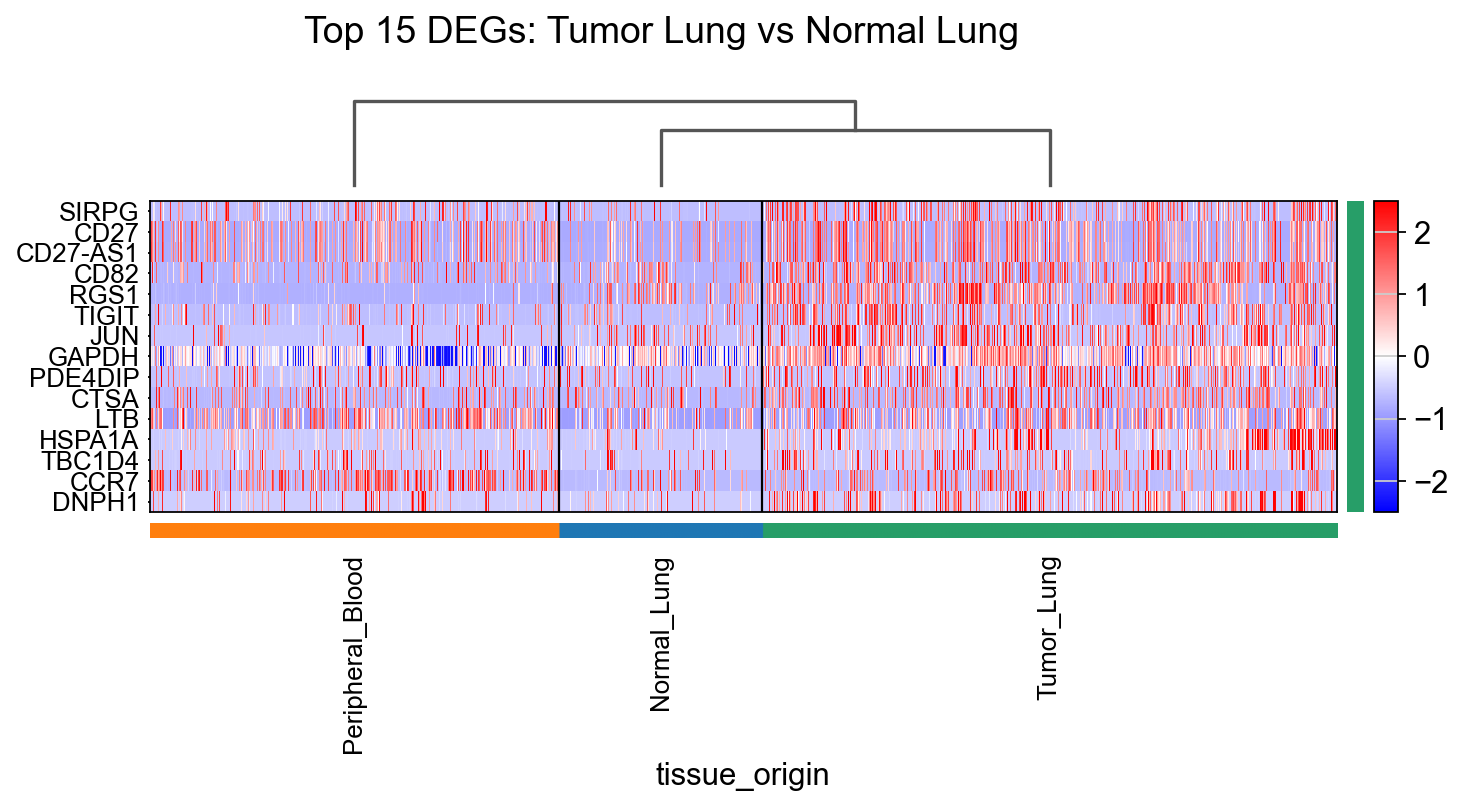

In [8]:
# B. Heatmap of top N differentially expressed genes
print("\nPlotting Heatmap of top DEGs...")
try:
            sc.pl.rank_genes_groups_heatmap(
                adata,
                n_genes=15, 
                key=dge_key,
                groups=['Tumor_Lung'], 
                groupby='tissue_origin', 
                show_gene_labels=True,
                swap_axes=True, 
                vmin=-2.5, 
                vmax=2.5,  
                cmap='bwr', 
                show=False
            )
            plt.suptitle('Top 15 DEGs: Tumor Lung vs Normal Lung', y=1.05) 
            plt.show()
except Exception as e:
    print(f"Could not generate heatmap: {e}")


Plotting Volcano Plot for Tumor_Lung vs Normal_Lung (Manual)...


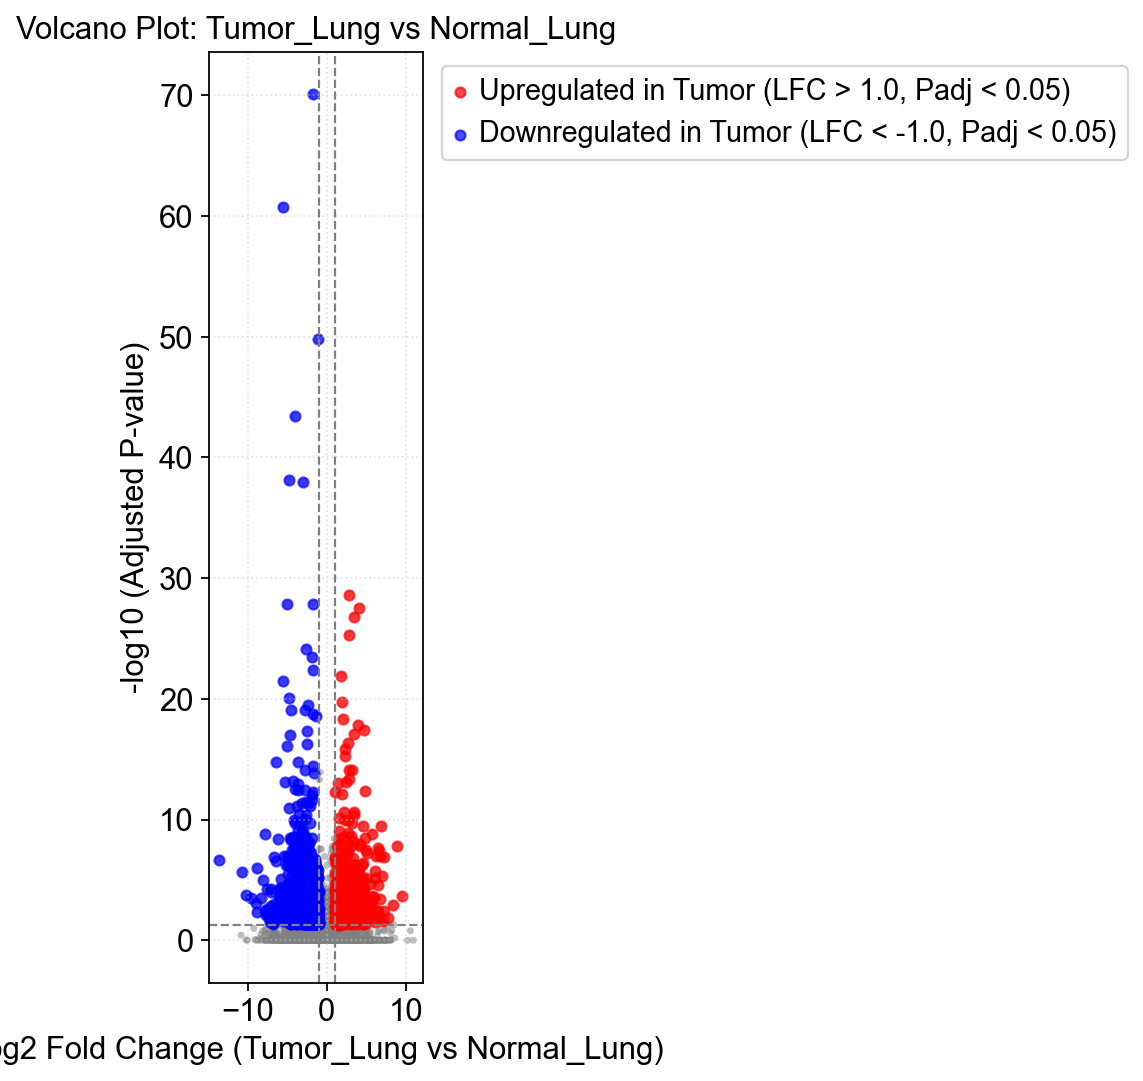

In [9]:
print("\nPlotting Volcano Plot for Tumor_Lung vs Normal_Lung (Manual)...")
try:
            # Extract results for the 'Tumor_Lung' group into a DataFrame
            if 'Tumor_Lung' in adata.uns[dge_key]['names'].dtype.names:
                dge_df = sc.get.rank_genes_groups_df(adata, group='Tumor_Lung', key=dge_key)

                # Create the volcano plot
                plt.figure(figsize=(8, 7))
                
                # Base scatter plot for all genes
                plt.scatter(dge_df['logfoldchanges'], -np.log10(dge_df['pvals_adj']), 
                            s=10, alpha=0.5, c='grey', edgecolors='none')

                # Define thresholds for significance (example values)
                logfc_threshold = 1.0  # Log2 fold change
                padj_threshold = 0.05  # Adjusted p-value

                # Highlight upregulated genes in Tumor_Lung
                up_regulated = dge_df[(dge_df['logfoldchanges'] > logfc_threshold) & (dge_df['pvals_adj'] < padj_threshold)]
                plt.scatter(up_regulated['logfoldchanges'], -np.log10(up_regulated['pvals_adj']), 
                            s=20, alpha=0.7, c='red', label=f'Upregulated in Tumor (LFC > {logfc_threshold}, Padj < {padj_threshold})')

                # Highlight downregulated genes in Tumor_Lung (upregulated in Normal_Lung)
                down_regulated = dge_df[(dge_df['logfoldchanges'] < -logfc_threshold) & (dge_df['pvals_adj'] < padj_threshold)]
                plt.scatter(down_regulated['logfoldchanges'], -np.log10(down_regulated['pvals_adj']), 
                            s=20, alpha=0.7, c='blue', label=f'Downregulated in Tumor (LFC < -{logfc_threshold}, Padj < {padj_threshold})')
                
                # Add labels for a few top genes (optional, can get very cluttered)
                # genes_to_label = pd.concat([
                #     up_regulated.sort_values(by='scores', ascending=False).head(10),
                #     down_regulated.sort_values(by='scores', ascending=True).head(10) # For wilcoxon, more negative scores are more significant for downregulated
                # ])
                # for i, row in genes_to_label.iterrows():
                #    plt.text(row['logfoldchanges'], -np.log10(row['pvals_adj']) + 0.1, row['names'], fontsize=8)

                plt.xlabel("Log2 Fold Change (Tumor_Lung vs Normal_Lung)")
                plt.ylabel("-log10 (Adjusted P-value)")
                plt.title("Volcano Plot: Tumor_Lung vs Normal_Lung")
                plt.axhline(-np.log10(padj_threshold), color='grey', linestyle='--', lw=1)
                plt.axvline(logfc_threshold, color='grey', linestyle='--', lw=1)
                plt.axvline(-logfc_threshold, color='grey', linestyle='--', lw=1)
                plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
                plt.grid(True, linestyle=':', alpha=0.5)
                plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
                plt.show()
            else:
                print("Could not find 'Tumor_Lung' group in DGE results to generate DataFrame for volcano plot.")

except Exception as e:
            print(f"Could not generate manual volcano plot: {e}")



Plotting Dot Plot of top DEGs...
categories: Normal_Lung, Peripheral_Blood, Tumor_Lung
var_group_labels: Tumor_Lung


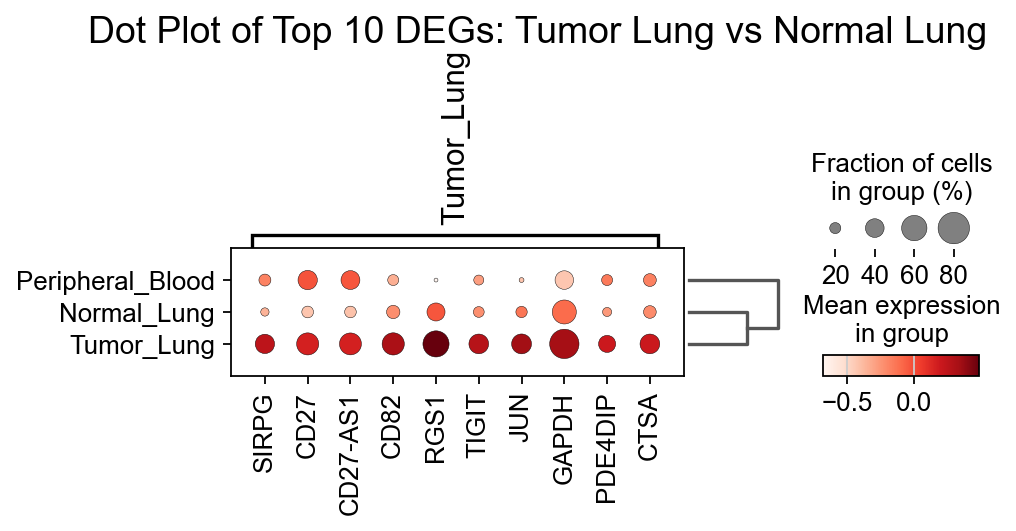

In [10]:
print("\nPlotting Dot Plot of top DEGs...")
try:
            sc.pl.rank_genes_groups_dotplot(
                adata,
                n_genes=10, 
                key=dge_key,
                groups=['Tumor_Lung'],
                groupby='tissue_origin',
                show=False
            )
            plt.suptitle('Dot Plot of Top 10 DEGs: Tumor Lung vs Normal Lung', y=1.05) 
            plt.show()
except Exception as e:
            print(f"Could not generate dotplot: {e}")


Plotting UMAPs for top DEGs in Tumor_Lung: ['SIRPG', 'CD27', 'CD27-AS1']...
Error plotting UMAPs for DEGs: PathCollection.set() got an unexpected keyword argument 'vmax_percentile'


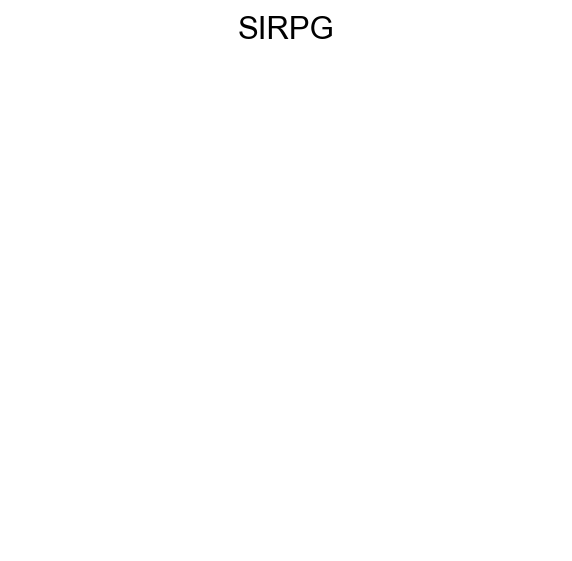

In [11]:
# D. UMAPs colored by expression of a few top DEGs
try:
            if 'Tumor_Lung' in adata.uns[dge_key]['names'].dtype.names:
                top_tumor_genes = adata.uns[dge_key]['names']['Tumor_Lung'][:3].tolist()
                
                if top_tumor_genes:
                    print(f"\nPlotting UMAPs for top DEGs in Tumor_Lung: {top_tumor_genes}...")
                    sc.pl.umap(adata, color=top_tumor_genes, show=False, cmap='viridis', vmax_percentile=99.5) 
                    plt.suptitle('UMAP Colored by Expression of Top DEGs (Upregulated in Tumor)', y=1.02)
                    plt.tight_layout()
                    plt.show()
            else:
                print(f"Could not find 'Tumor_Lung' results in adata.uns['{dge_key}']['names']")
except Exception as e:
            print(f"Error plotting UMAPs for DEGs: {e}")
